# GRU
LST은 좋은 계층이지만 매개변수가 많아서 계싼이 오래 걸린다. GRU는 게이트를 사용한다는 개념은 유지하면서 매개변수를 줄여 계산 시간을 줄였다.

## C.1 GRU의 인터페이스
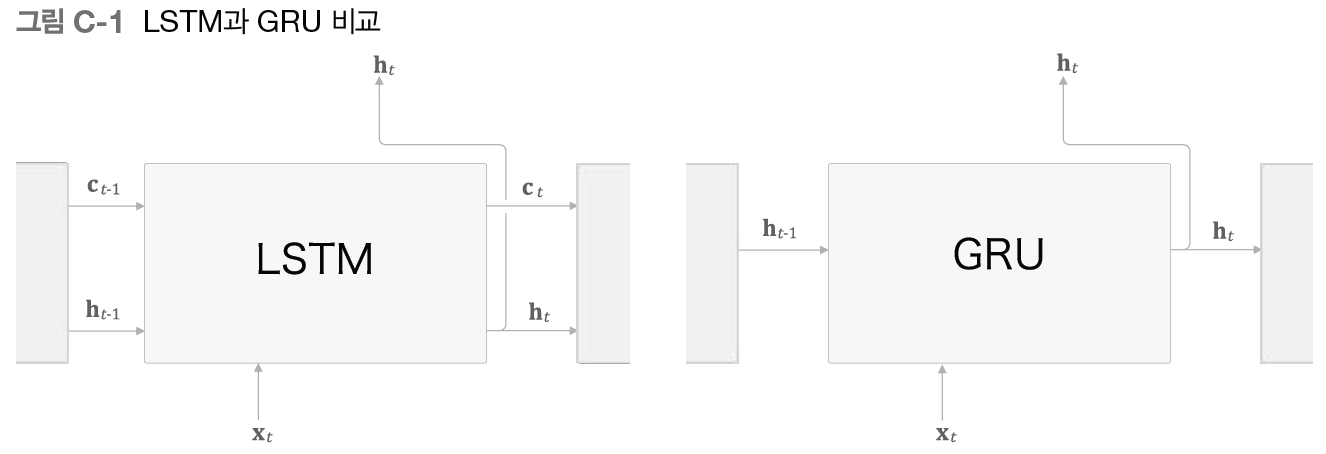

GRU는 LSTM과 달리 은닉 상태만 사용한다. 

## C.2 GRU의 계산 그래프
GRU에서 수행하는 계산식

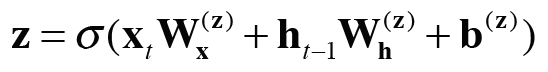

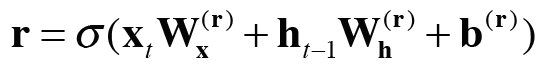

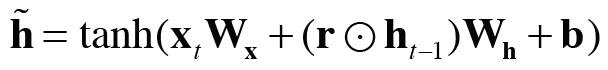

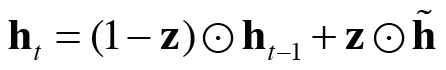

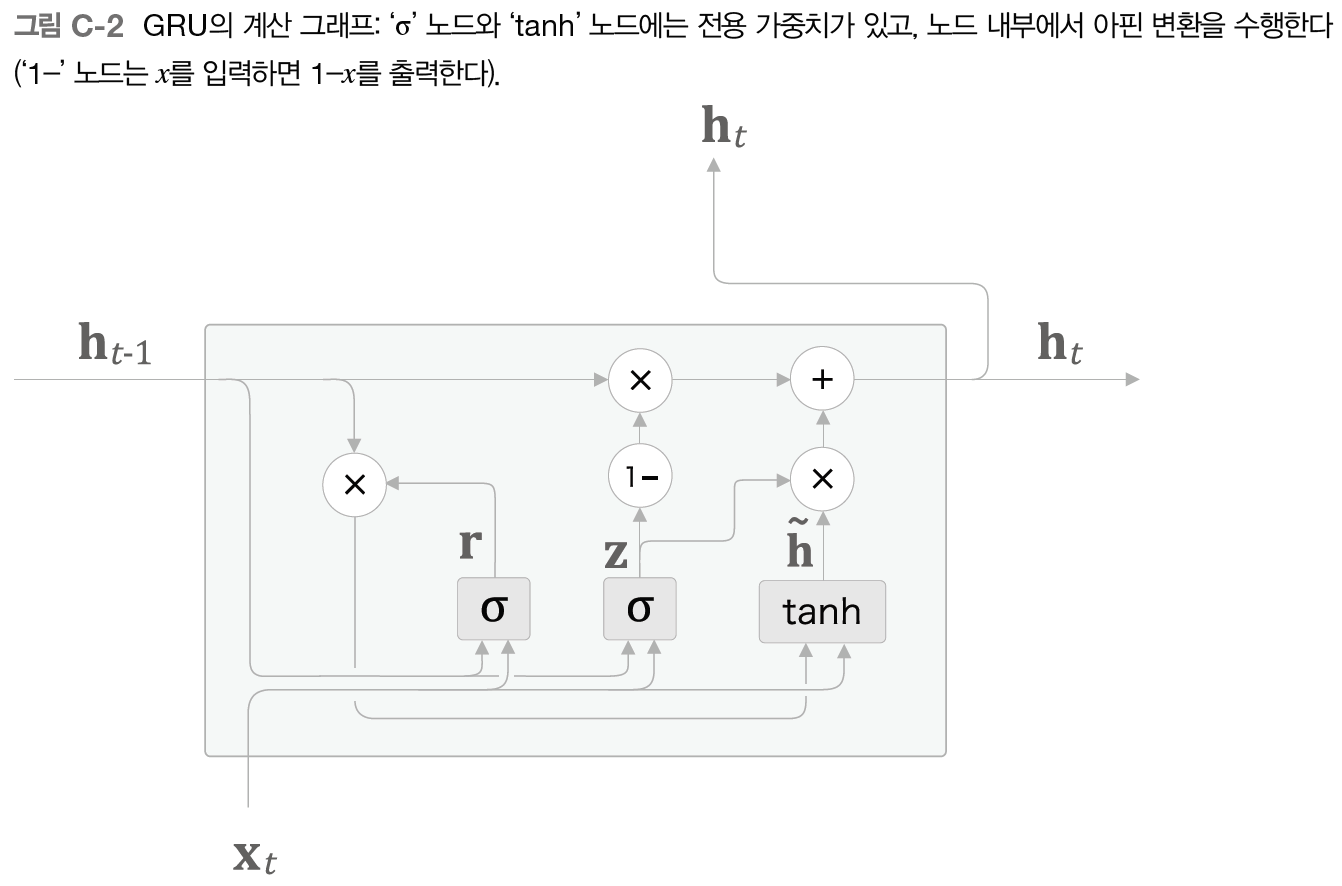

GRU는 기억 셀은 없고 시간 방향으로 전파하는 것은 은닉 상태 $\mathbf h$뿐이다. reset 게이트인 $\mathbf r$과 update 게이트인 $\mathbf z$라는 2개의 게이트를 사용한다. reset 게이트인 $\mathbf r$는 과거의 은닉 상태를 얼마나 '무시'할지를 정한다. 만약 $\mathbf r$이 0이면 과거의 은닉 상태는 완전히 무시되고 새로운 은닉 상태 $\mathbf {\tilde h}$는 입력 $\mathbf x_t$만으로 결정된다. update 게이트인 $\mathbf z$는 은닉 상태를 갱신하는 게이트이다. LSTM의 forget 게이트와 input 게이트의 역할을 혼자 담당한다. 이 계산에 의해 과거의 은닉 상태에서 잊어야 할 정보를 삭제하고, input 게이트로서의 역할은 $\mathbf z \odot \mathbf {\tilde h}$이다. 이로 로 인해 새로 추가된 정보에 input 게이트의 가중치를 부여한다. 

따라서 LSTM보다 계산비용과 매개변수의 수를 줄일 수 있다. GRU는 데이터셋이 작거나 모델 설계 시 반복 시도를 많이 해야할 경우 특히 적합하다. 

In [1]:
class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev

In [2]:
class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None